# Predictive Analysis of Type 2 Diabetes Using ML Model.
### (K-Nearest Neighbor(KNN) Classifier, Random Forest Classifier (RFC), Logistic Regression (LR))

In [125]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [126]:
# Import the dataset
dataset = pd.read_csv('dataset/diabetes.csv')
print(dataset.shape)
dataset.head()

(768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


## Perform data visualisation and pre-processing

In [127]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [128]:
dataset.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [129]:
dataset.isna().any()

Pregnancies                 False
Glucose                     False
BloodPressure               False
SkinThickness               False
Insulin                     False
BMI                         False
DiabetesPedigreeFunction    False
Age                         False
Outcome                     False
dtype: bool

<AxesSubplot:>

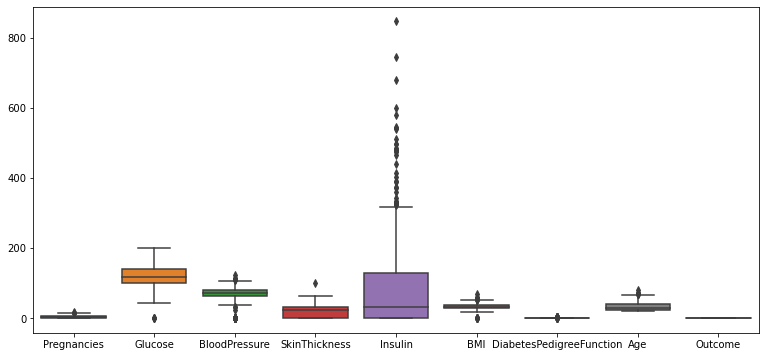

In [130]:
fig, ax = plt.subplots(figsize=(13, 6))
sns.boxplot(ax=ax, data=dataset)

## Handling outliers

As can be seen, there are some outliers existing in the dataset, in the 'Insulin' & 'SkinThickness' columns. Outliers represent inaccuracies during data collection. Hence, they can affect the model accuracy. So we remove them in the following step.

99th percentile of Insulin value = 519.9000000000012
99th percentile of SkinThickness value = 51.33000000000004


<AxesSubplot:>

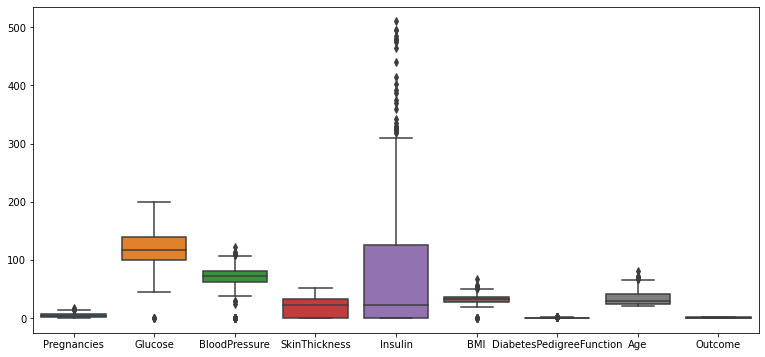

In [131]:
q_insulin = dataset['Insulin'].quantile(0.99)
q_skin = dataset['SkinThickness'].quantile(0.99)
print(f'99th percentile of Insulin value = {q_insulin}')
print(f'99th percentile of SkinThickness value = {q_skin}')

dataset = dataset[(dataset['Insulin'] < q_insulin) & (dataset['SkinThickness'] < q_skin)]

fig, ax = plt.subplots(figsize=(13, 6))
sns.boxplot(ax=ax, data=dataset)

## Handling missing values

It would be a serious medical problem if a patient had an insulin level and skin thickness measurement of zero. As such, we can conclude that this dataset uses the number zero to represent missing or null data. Here we can see that as many as half of the rows contain columns with missing data.

The number of pregnancies can be zero. But other features with missing values negatively affect our model’s performance. Therefore, we replace missing values in each attribute with the respective attribute’s mean.

In [132]:
# Find missing values
dataset2 = dataset.iloc[:, :-1]
print("# of Rows, # of Columns: ",dataset2.shape)
print("\nColumn Name           # of Null Values\n")
print((dataset2[:] == 0).sum())

# of Rows, # of Columns:  (752, 8)

Column Name           # of Null Values

Pregnancies                 106
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     371
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
dtype: int64


In [133]:
# Replace 0's with the means
missing_cols = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

for col in missing_cols:
    dataset[col] = dataset[col].replace(0, dataset[col].mean())
    
dataset2 = dataset.iloc[:, :-1]
print("# of Rows, # of Columns: ",dataset2.shape)
print("\nColumn Name           # of Null Values\n")
print((dataset2[:] == 0).sum())

# of Rows, # of Columns:  (752, 8)

Column Name           # of Null Values

Pregnancies                 106
Glucose                       0
BloodPressure                 0
SkinThickness                 0
Insulin                       0
BMI                           0
DiabetesPedigreeFunction      0
Age                           0
dtype: int64


### Splitting dataset into training and test sets

In [134]:
X = dataset.iloc[:, :-1].values
y = dataset.iloc[:, -1].values
print(X.shape)
print(y.shape)

(752, 8)
(752,)


In [135]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(601, 8)
(601,)
(151, 8)
(151,)


### Analyzing the relative number of 0's and 1's in outcomes

Counter({0: 386, 1: 215})


<BarContainer object of 2 artists>

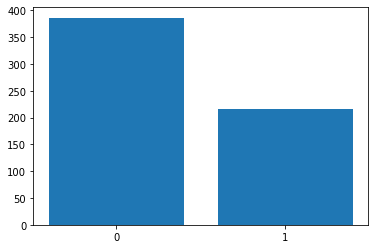

In [136]:
from collections import Counter
counter = Counter(y_train)
print(counter)

plt.bar(['0', '1'], [counter[0], counter[1]])

As can be seen in the above plot, the number of 0's and 1's is imbalanced. Training on this dataset will make our model better in predicting the cases in which a patient does not have diabetes, but we want our model to be accurate in predicting cases in which a patient has diabetes.

So, we use SMOTE (Synthetic Minority Oversampling Technique) to balance our data-set. SMOTE is a statistical technique used for increasing the number of instances in the dataset in a uniform way. This technique generates new instances from the existing minority instances.

In [137]:
from imblearn.over_sampling import SMOTE

smt = SMOTE()

X_train_sm, y_train_sm = smt.fit_resample(X_train, y_train)

print(Counter(y_train_sm))

Counter({0: 386, 1: 386})


### Feature scaling

In [138]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train_sm = sc.fit_transform(X_train_sm)
X_train_scaled = sc.fit_transform(X_train)

## Training the model

### Logistic Regression

In [165]:
from sklearn.linear_model import LogisticRegression
lrc = LogisticRegression()
lrc.fit(X_train_sm, y_train_sm)

LogisticRegression()

#### Predicting on test set and evaluating model performance

In [166]:
y_pred = lrc.predict(sc.transform(X_test))
print(y_pred)
print(y_test)

[1 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 1 0 0 1 0 1 0 1 0 0 1
 0 1 1 0 1 0 0 1 0 0 1 1 1 1 0 1 0 1 1 0 0 0 1 0 0 1 0 0 1 1 0 1 1 1 0 1 1
 0 0 0 0 1 1 0 0 1 1 0 0 0 0 0 0 1 1 1 0 0 1 0 1 0 0 0 0 0 1 1 0 0 1 1 1 0
 0 1 0 0 1 0 0 1 1 0 1 1 0 0 1 1 0 0 1 1 0 0 1 0 1 1 0 1 1 0 1 1 1 0 1 0 0
 1 1 0]
[0 0 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 1 0 0 0 0 1 1 0 0 1 0 1 0 1 0 0 1
 0 1 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 1 0 0 1 0 0 0 1 0 0 1 0 0 1 0
 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0 1 1 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 1 0 0
 0 1 0 0 0 1 0 0 1 0 1 1 1 0 1 1 0 0 0 1 0 0 1 0 0 1 0 0 0 0 1 0 0 0 0 0 0
 1 1 0]


In [167]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

In [168]:
# Print confusion matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)
lrc_accuracy = accuracy_score(y_test, y_pred)

print(f'Accuracy score in Logistic Regression = {lrc_accuracy}')
print(f'Precision score in Logistic Regression = {precision_score(y_test, y_pred)}')
print(f'Recall score in Logistic Regression = {recall_score(y_test, y_pred)}')
print(f'F1-score in Logistic Regression = {f1_score(y_test, y_pred)}')

[[75 31]
 [ 9 36]]
Accuracy score in Logistic Regression = 0.7350993377483444
Precision score in Logistic Regression = 0.5373134328358209
Recall score in Logistic Regression = 0.8
F1-score in Logistic Regression = 0.6428571428571428


### K-Nearest Neighbor Classifier

In [169]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train)

KNeighborsClassifier()

#### Predicting on test set and evaluating model performance

In [170]:
y_pred = knn.predict(sc.transform(X_test))
print(y_pred)
print(y_test)

[1 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 1 0 1 0 0 1
 0 1 1 0 0 0 0 0 0 0 0 1 1 1 0 1 0 1 0 0 0 0 1 0 0 0 0 0 1 1 0 0 1 0 0 1 1
 0 0 0 0 0 1 0 1 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 1 1 0
 0 1 0 0 1 1 0 1 1 0 1 0 1 0 1 0 0 0 1 1 0 0 0 0 1 1 0 1 1 0 1 0 1 0 0 0 0
 1 1 0]
[0 0 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 1 0 0 0 0 1 1 0 0 1 0 1 0 1 0 0 1
 0 1 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 1 0 0 1 0 0 0 1 0 0 1 0 0 1 0
 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0 1 1 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 1 0 0
 0 1 0 0 0 1 0 0 1 0 1 1 1 0 1 1 0 0 0 1 0 0 1 0 0 1 0 0 0 0 1 0 0 0 0 0 0
 1 1 0]


In [171]:
cm = confusion_matrix(y_test, y_pred)
print(cm)
knn_accuracy = accuracy_score(y_test, y_pred)

print(f'Accuracy score in K-Nearest Neighbor Classifier = {knn_accuracy}')
print(f'Precision score in K-Nearest Neighbor Classifier = {precision_score(y_test, y_pred)}')
print(f'Recall score in K-Nearest Neighbor Classifier = {recall_score(y_test, y_pred)}')
print(f'F1-score in K-Nearest Neighbor Classifier = {f1_score(y_test, y_pred)}')

[[89 17]
 [14 31]]
Accuracy score in K-Nearest Neighbor Classifier = 0.7947019867549668
Precision score in K-Nearest Neighbor Classifier = 0.6458333333333334
Recall score in K-Nearest Neighbor Classifier = 0.6888888888888889
F1-score in K-Nearest Neighbor Classifier = 0.6666666666666667


### Random Forest Classifier

In [172]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
rfc.fit(X_train_sm, y_train_sm)

RandomForestClassifier()

#### Predicting on test set and evaluating model performance

In [173]:
y_pred = rfc.predict(sc.transform(X_test))
print(y_pred)
print(y_test)

[0 0 1 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 1 1 0 0 0 1 1 0 0 1 0 1 0 1 0 0 1
 0 1 1 0 1 0 0 0 0 0 1 1 1 1 0 1 0 1 1 0 0 0 1 0 0 1 0 0 1 1 0 1 1 1 0 1 1
 0 0 0 0 0 1 0 1 1 0 0 0 0 1 1 1 1 1 1 0 0 1 0 1 0 0 0 0 0 0 1 0 0 1 1 1 0
 0 1 0 0 1 1 0 1 1 0 1 1 1 0 1 1 0 0 1 1 0 0 1 0 1 1 0 1 0 0 1 0 1 0 0 1 0
 1 1 0]
[0 0 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 1 0 0 0 0 1 1 0 0 1 0 1 0 1 0 0 1
 0 1 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 1 0 0 1 0 0 0 1 0 0 1 0 0 1 0
 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0 1 1 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 1 0 0
 0 1 0 0 0 1 0 0 1 0 1 1 1 0 1 1 0 0 0 1 0 0 1 0 0 1 0 0 0 0 1 0 0 0 0 0 0
 1 1 0]


In [174]:
cm = confusion_matrix(y_test, y_pred)
print(cm)
rfc_accuracy = accuracy_score(y_test, y_pred)

print(f'Accuracy score in Random Forest Classifier = {rfc_accuracy}')
print(f'Precision score in Random Forest Classifier = {precision_score(y_test, y_pred)}')
print(f'Recall score in Random Forest Classifier = {recall_score(y_test, y_pred)}')
print(f'F1-score in Random Forest Classifier = {f1_score(y_test, y_pred)}')

[[81 25]
 [ 2 43]]
Accuracy score in Random Forest Classifier = 0.8211920529801324
Precision score in Random Forest Classifier = 0.6323529411764706
Recall score in Random Forest Classifier = 0.9555555555555556
F1-score in Random Forest Classifier = 0.7610619469026547


## Conclusion

In [175]:
scores = pd.DataFrame({ 'Model': ['LR', 'KNN', 'RFC'], 'Score': [lrc_accuracy, knn_accuracy, rfc_accuracy] })
scores

,Model,Score
0,LR,0.735099
1,KNN,0.794702
2,RFC,0.821192


<AxesSubplot:xlabel='Model', ylabel='Score'>

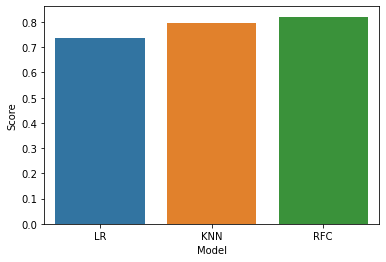

In [176]:
sns.barplot(x='Model', y='Score', data=scores)

As can be seen above, Random Forest Classifier has outperformed Logistic Regression as well as K-Nearest Neigbors Classification, because of higher accuracy, precision and recall scores.